# Weather Data Integration & Correlation Analysis

**Step 2:** Combine CEB electricity data with NASA POWER weather data to identify key features for solar forecasting.

---

## Objective
- Fetch monthly weather data for Maharagama from NASA POWER
- Merge with solar export patterns
- Analyze correlations to identify which weather factors drive solar generation

## 1. Setup

In [106]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

print("Libraries loaded")

Libraries loaded


In [107]:
# Configuration
LATITUDE = 6.8514   # Maharagama
LONGITUDE = 79.9211

print(f"Location: Maharagama ({LATITUDE}°N, {LONGITUDE}°E)")

Location: Maharagama (6.8514°N, 79.9211°E)


## 2. Fetch NASA POWER Weather Data

In [108]:
# NASA POWER API - Monthly actual data for 2025
NASA_API = "https://power.larc.nasa.gov/api/temporal/monthly/point"

# Weather parameters
PARAMS = {
    'ALLSKY_SFC_SW_DWN': 'Solar_Irradiance_GHI',        # kWh/m²/day
    'T2M': 'Temperature',                                # °C
    'T2M_MAX': 'Max_Temperature',                        # °C
    'T2M_MIN': 'Min_Temperature',                        # °C
    'RH2M': 'Humidity',                                  # %
    'PRECTOTCORR': 'Precipitation',                      # mm/day
    'WS10M': 'Wind_Speed',                               # m/s
    'CLRSKY_SFC_SW_DWN': 'Clear_Sky_GHI'                # kWh/m²/day
}

# Date range for 2025
START_DATE = "2024"
END_DATE   = "2025"

print("Parameters to fetch:")
for orig, readable in PARAMS.items():
    print(f"  • {readable}")
print(f"\nPeriod: 2025 (Jan-Dec)")

Parameters to fetch:
  • Solar_Irradiance_GHI
  • Temperature
  • Max_Temperature
  • Min_Temperature
  • Humidity
  • Precipitation
  • Wind_Speed
  • Clear_Sky_GHI

Period: 2025 (Jan-Dec)


In [109]:
# Fetch actual 2025 monthly data from NASA
params_str = ",".join(PARAMS.keys())
url = (
    f"{NASA_API}?"
    f"parameters={params_str}&"
    f"community=SB&"
    f"longitude={LONGITUDE}&"
    f"latitude={LATITUDE}&"
    f"start={START_DATE}&"
    f"end={END_DATE}&"
    f"format=JSON"
)

print("Fetching 2025 actual monthly data from NASA POWER API...")
print(f"Location: {LATITUDE}°N, {LONGITUDE}°E")
print(f"Period: Jan 2025 - Dec 2025")
print(f"\nURL: {url[:90]}...")

response = requests.get(url, timeout=30)
response.raise_for_status()
data_2025 = response.json()

print("Data received")

Fetching 2025 actual monthly data from NASA POWER API...
Location: 6.8514°N, 79.9211°E
Period: Jan 2025 - Dec 2025

URL: https://power.larc.nasa.gov/api/temporal/monthly/point?parameters=ALLSKY_SFC_SW_DWN,T2M,T2...
Data received


## 3. Labeling and missing value handling

In [110]:
# Parse 2025 data
weather_2025 = []

if data_2025:
    param_data = data_2025['properties']['parameter']
    
    for month in range(1, 13):
        date_key = f"2025{month:02d}"
        row = {'Month': month}
        
        for orig_name, readable_name in PARAMS.items():
            if date_key in param_data[orig_name]:
                row[readable_name] = param_data[orig_name][date_key]
            else:
                row[readable_name] = np.nan  # Mark as missing
        
        weather_2025.append(row)

weather_df = pd.DataFrame(weather_2025)

print(weather_df.shape)
weather_df.head(12)

(12, 9)


,Month,Solar_Irradiance_GHI,Temperature,Max_Temperature,Min_Temperature,Humidity,Precipitation,Wind_Speed,Clear_Sky_GHI
0,1,183.10,25.51,29.62,21.19,85.73,5.23,5.06,259.08
1,2,268.06,26.10,31.22,20.62,79.42,1.76,4.05,285.12
2,3,256.05,27.30,31.74,21.60,78.42,8.28,2.39,293.92
3,4,245.78,27.37,30.92,24.74,85.09,10.06,3.18,292.48
4,5,195.46,27.57,30.70,25.21,86.28,8.52,4.79,283.44
5,6,230.89,26.90,29.27,25.12,88.09,4.34,5.35,276.61
6,7,230.95,26.39,29.02,24.10,88.75,2.39,5.67,272.48
7,8,254.02,26.13,29.38,24.12,87.83,2.64,5.05,287.56
8,9,244.36,26.60,29.15,24.78,86.37,5.96,4.99,289.36
9,10,206.62,26.47,29.77,24.57,86.55,16.80,3.53,282.93


In [111]:
# Replace NASA fill value
weather_df.replace(-999.00, np.nan, inplace=True)

# Check missing data
missing_mask = weather_df['Solar_Irradiance_GHI'].isna()
missing_months = weather_df[missing_mask]['Month'].tolist()

print(f"✓ Parsed 12 months")
if missing_months:
    print(f"⚠ Missing data for months: {missing_months}")
    print(f"  (NASA has ~1-2 month lag for recent data)")
else:
    print(f"✓ All months have data")

print("\n2025 Weather Data (with readable names):")
weather_df.round(2)

✓ Parsed 12 months
⚠ Missing data for months: [11, 12]
  (NASA has ~1-2 month lag for recent data)

2025 Weather Data (with readable names):


,Month,Solar_Irradiance_GHI,Temperature,Max_Temperature,Min_Temperature,Humidity,Precipitation,Wind_Speed,Clear_Sky_GHI
0,1,183.10,25.51,29.62,21.19,85.73,5.23,5.06,259.08
1,2,268.06,26.10,31.22,20.62,79.42,1.76,4.05,285.12
2,3,256.05,27.30,31.74,21.60,78.42,8.28,2.39,293.92
3,4,245.78,27.37,30.92,24.74,85.09,10.06,3.18,292.48
4,5,195.46,27.57,30.70,25.21,86.28,8.52,4.79,283.44
5,6,230.89,26.90,29.27,25.12,88.09,4.34,5.35,276.61
6,7,230.95,26.39,29.02,24.10,88.75,2.39,5.67,272.48
7,8,254.02,26.13,29.38,24.12,87.83,2.64,5.05,287.56
8,9,244.36,26.60,29.15,24.78,86.37,5.96,4.99,289.36
9,10,206.62,26.47,29.77,24.57,86.55,16.80,3.53,282.93


In [112]:
if missing_months:
    print("\nFilling missing months with 5-year historical averages...")

    START_YEAR = 2018
    END_YEAR   = 2022

    url_hist = (
        f"{NASA_API}?"
        f"parameters=ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN&"
        f"community=SB&"
        f"longitude={LONGITUDE}&"
        f"latitude={LATITUDE}&"
        f"start={START_YEAR}&end={END_YEAR}&format=JSON"
    )

    try:
        data_hist = requests.get(url_hist, timeout=30).json()
        param_allsky = data_hist['properties']['parameter']['ALLSKY_SFC_SW_DWN']
        param_csky   = data_hist['properties']['parameter']['CLRSKY_SFC_SW_DWN']

        averages = {}
        for month in [11, 12]:
            vals_allsky = [param_allsky[f"{year}{month:02d}"] for year in range(2018, 2023) if param_allsky[f"{year}{month:02d}"] != -999]
            vals_csky   = [param_csky[f"{year}{month:02d}"] for year in range(2018, 2023) if param_csky[f"{year}{month:02d}"] != -999]
            
            averages[month] = {
                'Solar_Irradiance_GHI': round(sum(vals_allsky)/len(vals_allsky),2),
                'Clear_Sky_GHI': round(sum(vals_csky)/len(vals_csky),2)
            }

        for month in missing_months:
            weather_df.loc[weather_df['Month'].astype(int)==month, 'Solar_Irradiance_GHI'] = averages[month]['Solar_Irradiance_GHI']
            weather_df.loc[weather_df['Month'].astype(int)==month, 'Clear_Sky_GHI'] = averages[month]['Clear_Sky_GHI']

        print(f"✓ Filled missing months: {missing_months}")

    except Exception as e:
        print(f"✗ Could not fetch 5-year historical data: {e}")

# Print final DataFrame
weather_df.head(12)


Filling missing months with 5-year historical averages...
✓ Filled missing months: [11, 12]


,Month,Solar_Irradiance_GHI,Temperature,Max_Temperature,Min_Temperature,Humidity,Precipitation,Wind_Speed,Clear_Sky_GHI
0,1,183.10,25.51,29.62,21.19,85.73,5.23,5.06,259.08
1,2,268.06,26.10,31.22,20.62,79.42,1.76,4.05,285.12
2,3,256.05,27.30,31.74,21.60,78.42,8.28,2.39,293.92
3,4,245.78,27.37,30.92,24.74,85.09,10.06,3.18,292.48
4,5,195.46,27.57,30.70,25.21,86.28,8.52,4.79,283.44
5,6,230.89,26.90,29.27,25.12,88.09,4.34,5.35,276.61
6,7,230.95,26.39,29.02,24.10,88.75,2.39,5.67,272.48
7,8,254.02,26.13,29.38,24.12,87.83,2.64,5.05,287.56
8,9,244.36,26.60,29.15,24.78,86.37,5.96,4.99,289.36
9,10,206.62,26.47,29.77,24.57,86.55,16.80,3.53,282.93


## 3. Load Solar Export Data

In [113]:
# Load CEB data
df = pd.read_csv('../../processed/MASTER_DATASET_ALL_10TRANSFORMERS.csv')

# Filter solar accounts
solar = df[df['HAS_SOLAR'] == 1].copy()

print(f"Solar records: {len(solar)}")
print(f"Solar accounts: {solar['ACCOUNT_NO'].nunique()}")

Solar records: 3036
Solar accounts: 253


In [114]:
# Calculate monthly average export
monthly_export = solar.groupby('MONTH').agg({
    'EXPORT_kWh': ['mean', 'std', 'min', 'max', 'count']
}).reset_index()

monthly_export.columns = ['MONTH', 'export_mean', 'export_std', 'export_min', 'export_max', 'export_count']
monthly_export.rename(columns={'MONTH': 'Month'}, inplace=True)

print("Monthly Export Statistics:")
monthly_export

Monthly Export Statistics:


,Month,export_mean,export_std,export_min,export_max,export_count
0,1,478.133676,115.530444,228.66,1000.00,253
1,2,502.469565,125.459095,195.68,1000.00,253
2,3,522.525375,128.841336,233.75,1000.00,253
3,4,500.541542,123.208994,256.18,1000.00,253
4,5,430.915613,111.303121,191.60,1000.00,253
5,6,259.621225,70.391426,120.38,801.31,253
6,7,282.241779,79.036652,139.90,916.99,253
7,8,309.646166,89.103062,138.38,1000.00,253
8,9,438.103636,158.422112,122.66,1620.02,253
9,10,447.173874,147.777491,0.00,1569.76,253


## 4. Merge Weather + Export Data

In [115]:
# Merge datasets
merged = monthly_export.merge(weather_df, on='Month', how='left')

# Add data quality flag (which months have real export data)
merged['DATA_TYPE'] = merged['Month'].apply(lambda x: 'REAL' if x in [9, 10, 11] else 'SYNTHETIC')

print(f"Merged shape: {merged.shape}")

print("\nCombined Dataset:")
merged.round(2)

Merged shape: (12, 15)

Combined Dataset:


,Month,export_mean,export_std,export_min,export_max,export_count,Solar_Irradiance_GHI,Temperature,Max_Temperature,Min_Temperature,Humidity,Precipitation,Wind_Speed,Clear_Sky_GHI,DATA_TYPE
0,1,478.13,115.53,228.66,1000.00,253,183.10,25.51,29.62,21.19,85.73,5.23,5.06,259.08,SYNTHETIC
1,2,502.47,125.46,195.68,1000.00,253,268.06,26.10,31.22,20.62,79.42,1.76,4.05,285.12,SYNTHETIC
2,3,522.53,128.84,233.75,1000.00,253,256.05,27.30,31.74,21.60,78.42,8.28,2.39,293.92,SYNTHETIC
3,4,500.54,123.21,256.18,1000.00,253,245.78,27.37,30.92,24.74,85.09,10.06,3.18,292.48,SYNTHETIC
4,5,430.92,111.30,191.60,1000.00,253,195.46,27.57,30.70,25.21,86.28,8.52,4.79,283.44,SYNTHETIC
5,6,259.62,70.39,120.38,801.31,253,230.89,26.90,29.27,25.12,88.09,4.34,5.35,276.61,SYNTHETIC
6,7,282.24,79.04,139.90,916.99,253,230.95,26.39,29.02,24.10,88.75,2.39,5.67,272.48,SYNTHETIC
7,8,309.65,89.10,138.38,1000.00,253,254.02,26.13,29.38,24.12,87.83,2.64,5.05,287.56,SYNTHETIC
8,9,438.10,158.42,122.66,1620.02,253,244.36,26.60,29.15,24.78,86.37,5.96,4.99,289.36,REAL
9,10,447.17,147.78,0.00,1569.76,253,206.62,26.47,29.77,24.57,86.55,16.80,3.53,282.93,REAL


## 5. Correlation Analysis

In [116]:
# Calculate correlation for ALL 12 months
print("CORRELATION ANALYSIS (All 12 Months)")
print("="*70)

correlations_all = {}
for param in PARAMS.values():
    # Remove NaN values if any
    valid_data = merged[[param, 'export_mean']].dropna()
    if len(valid_data) > 2:
        corr, p_value = stats.pearsonr(valid_data[param], valid_data['export_mean'])
        correlations_all[param] = {'correlation': corr, 'p_value': p_value}

# Sort by strength
sorted_corr_all = sorted(correlations_all.items(), key=lambda x: abs(x[1]['correlation']), reverse=True)

for param, values in sorted_corr_all:
    corr = values['correlation']
    p_val = values['p_value']
    strength = "STRONG" if abs(corr) > 0.7 else "MODERATE" if abs(corr) > 0.4 else "WEAK"
    sig = "***" if p_val < 0.01 else "**" if p_val < 0.05 else "*" if p_val < 0.1 else ""
    print(f"{param:25} : {corr:+.3f}  [{strength:8}] {sig}")

print("\n" + "="*70)
print("CORRELATION ANALYSIS (REAL DATA ONLY - Sep/Oct/Nov)")
print("="*70)

# Filter only real data months
real_only = merged[merged['DATA_TYPE'] == 'REAL'].copy()

correlations_real = {}
for param in PARAMS.values():
    valid_data = real_only[[param, 'export_mean']].dropna()
    if len(valid_data) >= 3:  # Need at least 3 points
        corr, p_value = stats.pearsonr(valid_data[param], valid_data['export_mean'])
        correlations_real[param] = {'correlation': corr, 'p_value': p_value}

sorted_corr_real = sorted(correlations_real.items(), key=lambda x: abs(x[1]['correlation']), reverse=True)

for param, values in sorted_corr_real:
    corr = values['correlation']
    p_val = values['p_value']
    strength = "STRONG" if abs(corr) > 0.7 else "MODERATE" if abs(corr) > 0.4 else "WEAK"
    sig = "***" if p_val < 0.01 else "**" if p_val < 0.05 else "*" if p_val < 0.1 else ""
    print(f"{param:25} : {corr:+.3f}  [{strength:8}] {sig}")

print("\nNote: Real data correlation more reliable (actual weather + export)")
print("      All months correlation affected by synthetic export data")
print("\nSignificance: *** p<0.01, ** p<0.05, * p<0.1")

# Store both for later use
correlations = correlations_all  # Use all months as primary for consistency

CORRELATION ANALYSIS (All 12 Months)
Humidity                  : -0.735  [STRONG  ] ***
Wind_Speed                : -0.727  [STRONG  ] ***
Max_Temperature           : +0.693  [MODERATE] **
Min_Temperature           : -0.550  [MODERATE] *
Precipitation             : +0.271  [WEAK    ] 
Clear_Sky_GHI             : +0.069  [WEAK    ] 
Solar_Irradiance_GHI      : -0.021  [WEAK    ] 
Temperature               : +0.006  [WEAK    ] 

CORRELATION ANALYSIS (REAL DATA ONLY - Sep/Oct/Nov)
Humidity                  : +0.991  [STRONG  ] *
Min_Temperature           : +0.836  [STRONG  ] 
Clear_Sky_GHI             : +0.781  [STRONG  ] 
Temperature               : +0.767  [STRONG  ] 
Max_Temperature           : -0.486  [MODERATE] 
Precipitation             : -0.326  [WEAK    ] 
Wind_Speed                : -0.284  [WEAK    ] 
Solar_Irradiance_GHI      : +0.019  [WEAK    ] 

Note: Real data correlation more reliable (actual weather + export)
      All months correlation affected by synthetic export data


## 6. Visualization: Key Correlations

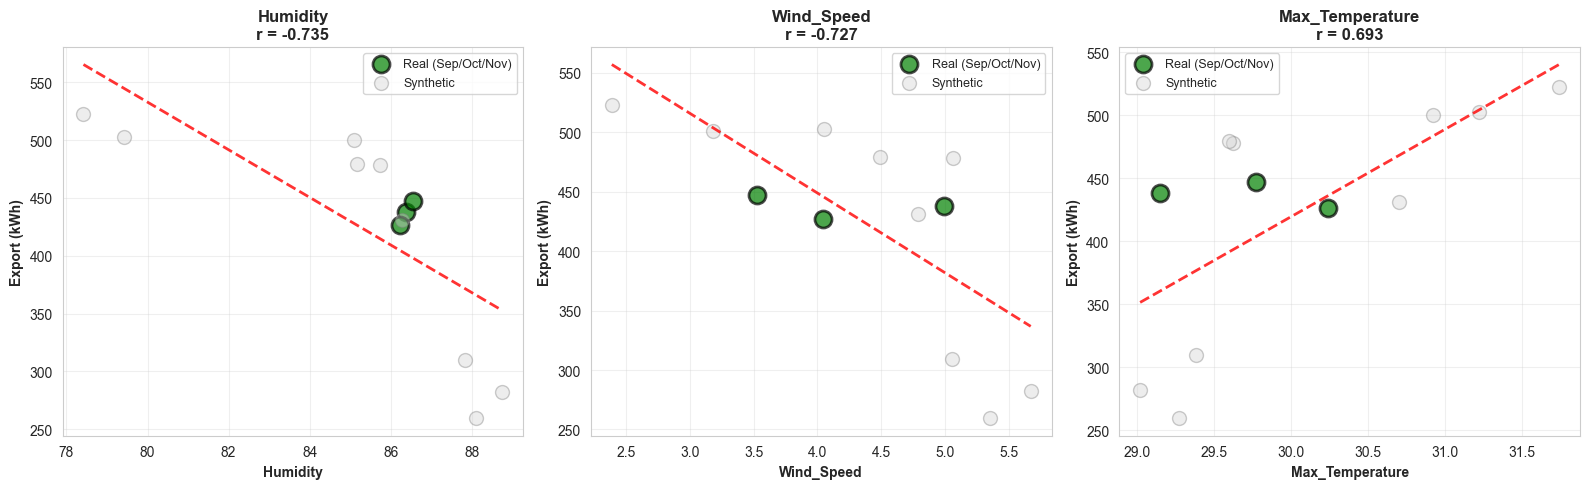

In [117]:
# Top 3 correlations (from all months analysis)
top_3 = sorted_corr_all[:3]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, (param, values) in enumerate(top_3):
    ax = axes[i]
    
    # Scatter plot with different colors for real vs synthetic
    real_mask = merged['DATA_TYPE'] == 'REAL'
    ax.scatter(merged[real_mask][param], merged[real_mask]['export_mean'], 
              s=150, alpha=0.7, edgecolor='black', linewidth=2, 
              label='Real (Sep/Oct/Nov)', c='green')
    ax.scatter(merged[~real_mask][param], merged[~real_mask]['export_mean'], 
              s=100, alpha=0.4, edgecolor='gray', 
              label='Synthetic', c='lightgray')
    
    # Trend line (using all data)
    valid_data = merged[[param, 'export_mean']].dropna()
    z = np.polyfit(valid_data[param], valid_data['export_mean'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(valid_data[param].min(), valid_data[param].max(), 100)
    ax.plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.8)
    
    # Labels
    param_short = param.replace('ALLSKY_SFC_SW_DWN', 'GHI').replace('CLRSKY_SFC_SW_DWN', 'Clear GHI')
    ax.set_xlabel(param_short, fontweight='bold')
    ax.set_ylabel('Export (kWh)', fontweight='bold')
    ax.set_title(f"{param_short}\nr = {values['correlation']:.3f}", fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

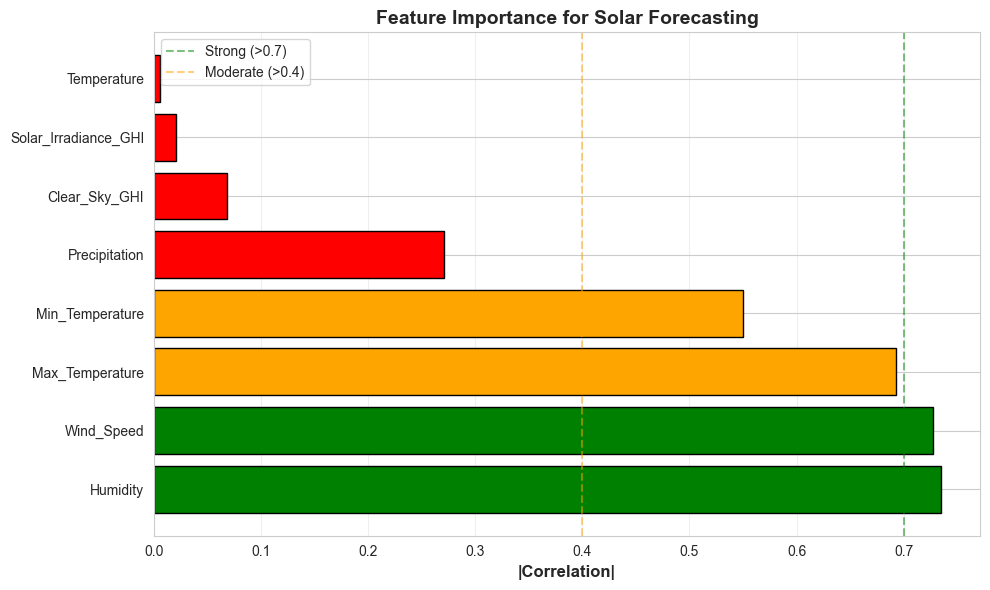

In [118]:
# Feature importance ranking
param_names = [k for k, v in sorted_corr_all]
param_corrs = [abs(v['correlation']) for k, v in sorted_corr_all]

# Color by strength
colors = ['green' if c > 0.7 else 'orange' if c > 0.4 else 'red' for c in param_corrs]

plt.figure(figsize=(10, 6))
plt.barh(range(len(param_names)), param_corrs, color=colors, edgecolor='black')
plt.yticks(range(len(param_names)), 
           [p.replace('ALLSKY_SFC_SW_DWN', 'GHI').replace('CLRSKY_SFC_SW_DWN', 'Clear GHI') 
            for p in param_names])
plt.xlabel('|Correlation|', fontweight='bold', fontsize=12)
plt.title('Feature Importance for Solar Forecasting', fontweight='bold', fontsize=14)
plt.axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='Strong (>0.7)')
plt.axvline(x=0.4, color='orange', linestyle='--', alpha=0.5, label='Moderate (>0.4)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Monthly Pattern Comparison

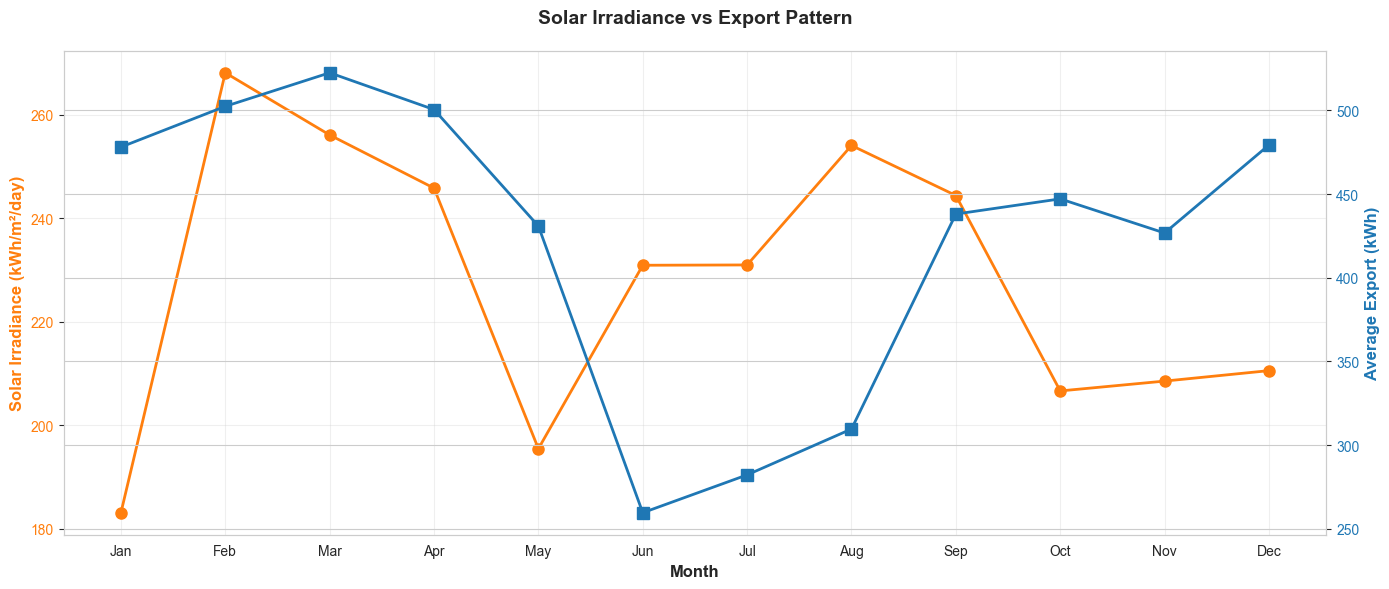

In [119]:
# Compare GHI vs Export trends
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax1 = plt.subplots(figsize=(14, 6))

# GHI on left axis
color1 = 'tab:orange'
ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
ax1.set_ylabel('Solar Irradiance (kWh/m²/day)', color=color1, fontsize=12, fontweight='bold')
ax1.plot(merged['Month'], merged['Solar_Irradiance_GHI'], 
         marker='o', linewidth=2, markersize=8, color=color1, label='GHI')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(months)
ax1.grid(True, alpha=0.3)

# Export on right axis
ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Average Export (kWh)', color=color2, fontsize=12, fontweight='bold')
ax2.plot(merged['Month'], merged['export_mean'], 
         marker='s', linewidth=2, markersize=8, color=color2, label='Export')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Solar Irradiance vs Export Pattern', fontsize=14, fontweight='bold', pad=20)
fig.tight_layout()
plt.show()

## 8. Correlation Matrix

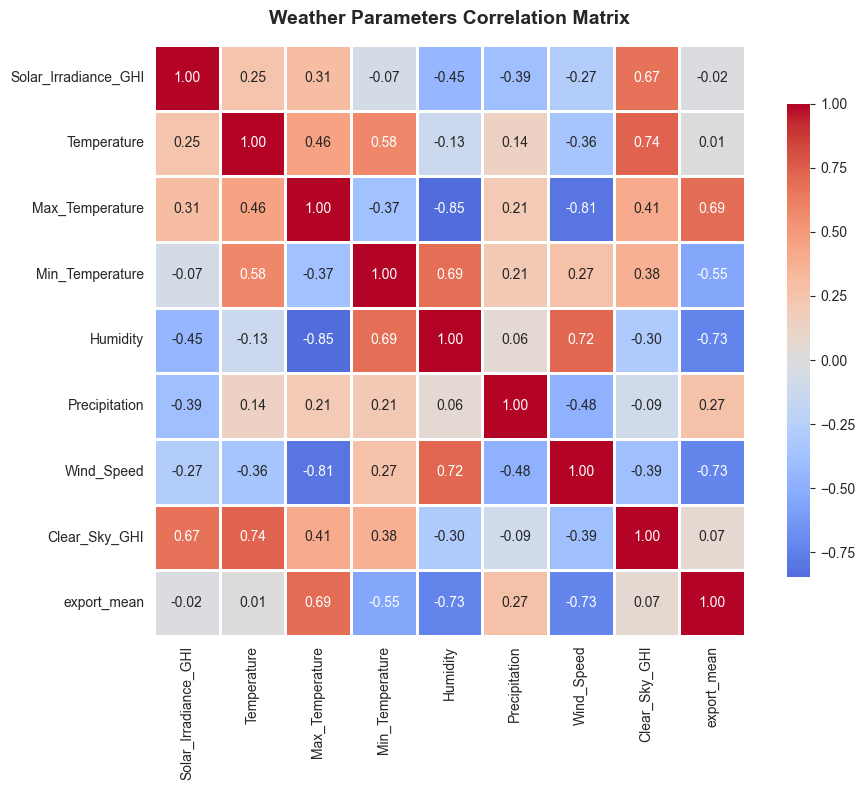

In [120]:
corr_matrix = merged[list(PARAMS.values()) + ['export_mean']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Weather Parameters Correlation Matrix', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()